In [2]:
traj_data_save_path = 'trajectories.pkl'

import pickle


with open(traj_data_save_path, 'rb') as file:
    traj_data = pickle.load(file)



In [18]:
len(traj_data)

2088

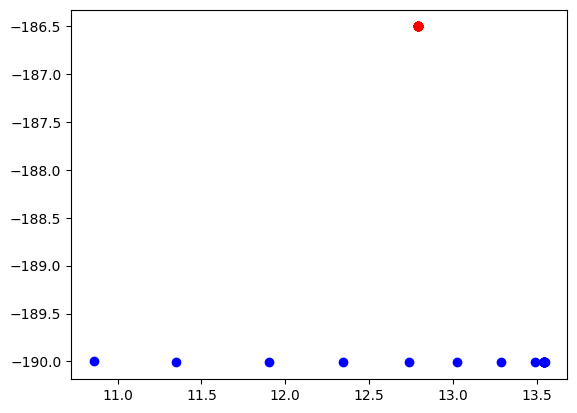

In [24]:
import matplotlib.pyplot as plt
for i in range(len(traj_data)):
    feature = traj_data[i][0]
    label = traj_data[i][1]
    for j in range(len(feature)):
        trajectory = feature[j]
        # 提取第三列为1的点的坐标
        x_points = [point[0] for point in trajectory if point[2] == 1.0]
        y_points = [point[1] for point in trajectory if point[2] == 1.0]
        if j ==0:
            plt.scatter(x_points, y_points, c='red')
        else:
            plt.scatter(x_points, y_points, c='blue')

    break

In [49]:
import os
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
def read_and_concatenate_files(folder_path):
    trajectory_data = pd.DataFrame()

    for file in os.listdir(folder_path):
        filepath = os.path.join(folder_path, file)
        if os.path.isfile(filepath):  
            df = pd.read_csv(filepath, names=['vehicle_id', 'timestamp', 'x', 'y'])
            trajectory_data = pd.concat([trajectory_data, df], ignore_index=True)

    return trajectory_data
folder_path = 'trajectories'
traj_data = []
all_timestamps = range(600)
for root, dirs, files in os.walk(folder_path):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        print(f"当前文件夹: {folder_path}")

        trajectory_data = read_and_concatenate_files(folder_path)

        # 按时间戳和车辆ID排序， trajectory_data是600帧的全部轨迹
        trajectory_data = trajectory_data.sort_values(by=['timestamp', 'vehicle_id'])
        grouped_vehicle = trajectory_data.groupby('vehicle_id')
        grouped_timestamp = trajectory_data.groupby('timestamp')

        # 顺序选择目标车辆，并按照时间戳分组，每个时间戳下的others车辆按距离筛选
        a = 0
        for vehicle_id, group in tqdm(grouped_vehicle):
            target_vehicle = group
            a += 1
            if a == 2:
                break

        break
    break

当前文件夹: trajectories\Town05_duration_600_20231110201856


  1%|          | 1/84 [00:00<00:00, 285.25it/s]


In [106]:
import os
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm


def read_and_concatenate_files(folder_path):
    trajectory_data = pd.DataFrame()

    for file in os.listdir(folder_path):
        filepath = os.path.join(folder_path, file)
        if os.path.isfile(filepath):  
            df = pd.read_csv(filepath, names=['vehicle_id', 'timestamp', 'x', 'y'])
            trajectory_data = pd.concat([trajectory_data, df], ignore_index=True)

    return trajectory_data



def filter_nearby_vehicles(target_id, target_vehicle, grouped):
    target_others_info = []

    for timestamp, group in grouped:
        # 通过timestamp在target_vehicle中筛选出目标车辆的信息
        target_info = target_vehicle[target_vehicle['timestamp'] == timestamp]

        # 确保目标信息非空
        if not target_info.empty:
            # 提取目标车辆的 x 和 y 值
            x_target = target_info['x'].values[0]
            y_target = target_info['y'].values[0]

            # 排除目标车辆，计算其他车辆到目标车辆的距离
            others = group[group['vehicle_id'] != target_id]
            others = others.assign(distance=np.sqrt((others['x'] - x_target) ** 2 + (others['y'] - y_target) ** 2))
            nearby_vehicles = others[others['distance'] < 30]

            # 将目标车辆和周围车辆的信息加入 target_others_info
            target_others_info.append({'timestamp': timestamp, 'x_target': x_target, 'y_target': y_target})

            other_vehicles_info = nearby_vehicles[['vehicle_id', 'timestamp', 'x', 'y']].to_dict(orient='records')
            target_others_info.extend(other_vehicles_info)

    target_others_info_df = pd.DataFrame(target_others_info, columns=['vehicle_id', 'timestamp', 'x', 'y'])
    target_others_info_df['timestamp'] = target_others_info_df['timestamp'].astype(int)
    return target_others_info_df



def process_vehicle_data(target_id, target_group, filtered_df, all_timestamps):
    filtered_df['frame_exists'] = 1
    grouped_by_vehicle = filtered_df.groupby('vehicle_id')

    processed_data = []
    all_data_template = pd.DataFrame({'timestamp': all_timestamps})

    for vehicle_id, group in grouped_by_vehicle:
        if vehicle_id == target_id:
            target_group = group
            continue

        all_data = all_data_template.copy()
        all_data['vehicle_id'] = vehicle_id
        merged_data = pd.merge(all_data, group, on=['timestamp', 'vehicle_id'], how='left').fillna(0.0)
        processed_data.append(merged_data)

    all_data = all_data_template.copy()
    all_data['vehicle_id'] = target_id
    merged_target_data = pd.merge(all_data, target_group, on=['timestamp', 'vehicle_id'], how='left').fillna(0.0)
    processed_data.insert(0, merged_target_data)

    return processed_data



def slice_data_frames(processed_data, slice_size=50, duration=600):
    sliced_data = []
    for t in range(duration // slice_size):
        start = t * slice_size
        end = (t + 1) * slice_size
        sliced_df_list = [vehicle_df.iloc[start:end].copy() for vehicle_df in processed_data]
        sliced_data.append(sliced_df_list)

    return sliced_data



def construct_features_and_labels(sliced_data, traj_data):
    # 对每个样本进行处理
    for sliced_df_list in sliced_data:
        # 提取标签（后30帧）
        label = sliced_df_list[0][['x', 'y', 'frame_exists']][20:].values.tolist()

        # 构建特征（前20帧）
        feature_list = []
        for vehicle_df in sliced_df_list:
            if vehicle_df[:20]['frame_exists'].eq(0.0).all():
                continue
            features = vehicle_df[['x', 'y', 'frame_exists']][:20].values.tolist()
            feature_list.append(features)
        traj_data.append([feature_list, label])
    
    return traj_data



folder_path = 'trajectories'
traj_data = []
all_timestamps = range(600)
for root, dirs, files in os.walk(folder_path):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        print(f"当前文件夹: {folder_path}")

        trajectory_data = read_and_concatenate_files(folder_path)

        # 按时间戳和车辆ID排序， trajectory_data是600帧的全部轨迹
        trajectory_data = trajectory_data.sort_values(by=['timestamp', 'vehicle_id'])
        grouped_vehicle = trajectory_data.groupby('vehicle_id')
        grouped_timestamp = trajectory_data.groupby('timestamp')

        # 顺序选择目标车辆，并按照时间戳分组，每个时间戳下的others车辆按距离筛选
        for vehicle_id, group in tqdm(grouped_vehicle):
            target_group = group
            target_others_info_df = filter_nearby_vehicles(vehicle_id, target_group, grouped_timestamp)
            processed_data = process_vehicle_data(vehicle_id, target_group, target_others_info_df, all_timestamps)
            sliced_data = slice_data_frames(processed_data)
            traj_data = construct_features_and_labels(sliced_data, traj_data)
            break

    break



当前文件夹: trajectories\Town05_duration_600_20231110201856


  0%|          | 0/84 [00:01<?, ?it/s]


KeyError: "['frame_exists'] not in index"

In [150]:
target_id, target_vehicle, grouped = vehicle_id, target_group, grouped_timestamp

target_area_vehicles = pd.DataFrame()

for timestamp, group in grouped:
    target_info = target_vehicle[target_vehicle['timestamp'] == timestamp]
    target_area_vehicles = target_area_vehicles.append(target_info, ignore_index=True)

    # 确保目标信息非空
    if not target_info.empty:
        x_target, y_target = target_info['x'].values[0], target_info['y'].values[0]

        # 计算每行的距离
        group['distance_to_target'] = np.sqrt((group['x'] - x_target) ** 2 + (group['y'] - y_target) ** 2)

        # 筛选条件：vehicle_id不等于target_id且距离小于30
        filtered_group = group[(group['vehicle_id'] != target_id) & (group['distance_to_target'] < 30)]

        # 逐步追加数据到目标数据框
        target_area_vehicles = target_area_vehicles.append(filtered_group, ignore_index=True)


In [151]:
target_area_vehicles

,vehicle_id,timestamp,x,y,distance_to_target
0,271,0,10.856620,-189.999023,3.995758
1,271,1,11.350126,-190.001129,3.969725
2,271,2,11.904203,-190.003418,3.933526
3,271,3,12.345548,-190.005325,3.916658
4,271,4,12.737292,-190.007004,3.917119
...,...,...,...,...,...
368,259,264,127.872391,-204.067551,23.834797
369,259,265,126.785667,-204.358536,24.890767
370,259,266,125.710953,-204.622787,26.011888
371,259,267,124.572685,-204.886551,27.271734


In [127]:
target_others_info_df

,vehicle_id,timestamp,x,y
0,252,0,NaN,NaN
1,271,0,10.856620,-189.999023
2,252,1,NaN,NaN
3,271,1,11.350126,-190.001129
4,252,2,NaN,NaN
...,...,...,...,...
968,252,595,NaN,NaN
969,252,596,NaN,NaN
970,252,597,NaN,NaN
971,252,598,NaN,NaN


In [102]:
target_id, target_group, filtered_df, all_timestamps = vehicle_id, target_group, target_others_info_df, all_timestamps
filtered_df['frame_exists'] = 1
grouped_by_vehicle = filtered_df.groupby('vehicle_id')

processed_data = []
all_data_template = pd.DataFrame({'timestamp': all_timestamps})

for vehicle_id, group in grouped_by_vehicle:
    # 找到缺失的时间戳
    missing_timestamps = set(range(0, 600)).difference(set(group['timestamp']))

    # 为每个缺失的时间戳创建一行，将'x' 'y' 'frame_exists'三个值填充为0
    for timestamp in missing_timestamps:
        group = group.append({'vehicle_id': vehicle_id, 'timestamp': timestamp, 'x': 0, 'y': 0, 'frame_exists': 0}, ignore_index=True)

    # 对结果按照 timestamp 进行排序
    group.sort_values(by='timestamp', inplace=True)

    # 将处理好的数据加入 processed_data
    processed_data.append(group)
    break


In [105]:
group

,vehicle_id,timestamp,x,y,frame_exists
32,255.0,0.0,0.0,0.0,0.0
33,255.0,1.0,0.0,0.0,0.0
34,255.0,2.0,0.0,0.0,0.0
35,255.0,3.0,0.0,0.0,0.0
36,255.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...
595,255.0,595.0,0.0,0.0,0.0
596,255.0,596.0,0.0,0.0,0.0
597,255.0,597.0,0.0,0.0,0.0
598,255.0,598.0,0.0,0.0,0.0
